In [72]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keplergl import KeplerGl
import sys
# isplay all columns
pd.set_option('display.max_columns', None)
sys.path.append('../utils/')
from functions import get_zone_info

In [73]:
# Load data
cph = gpd.read_file('../data/processed/cop_area.shp')
dr_trips = pd.read_csv('../data/processed/dr_oneway_spacial.csv')
car_trips = pd.read_csv('../data/processed/alltrips_cars.csv')
# read the txt file "stops.txt" and create a pandas dataframe
stops = pd.read_csv('../data/processed/stops.txt', sep=',')

C:\Users\mihai\AppData\Local\Temp\ipykernel_25112\175736875.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  car_trips = pd.read_csv('../data/processed/alltrips_cars.csv')


In [74]:
# keep columns: stop_name, stop_lat, stop_lon
stops = stops[['stop_name', 'stop_lat', 'stop_lon']]
stops.head()

,stop_name,stop_lat,stop_lon
0,Dyrupgårds Alle (Odense Kommune),55.354918,10.345035
1,Vipperød St.,55.666828,11.738710
2,Holbæk St.,55.715750,11.708598
3,Hvalsø St.,55.595537,11.859821
4,Tølløse St.,55.611893,11.772803


In [75]:
# sort cph by zonedescri and print head
cph = cph.sort_values(by='zonedescri')
cph.head()

,OBJECTID,komnr,zoneid,zonenavn,zonedescri,numadresse,Shape_Leng,Shape_Area,geometry
204,6622,165,165032,Albertslund syd S,Albertslund Kommune,719,2833.998761,3.999415e+05,"POLYGON ((710843.199 6173082.418, 710889.352 6..."
913,7366,165,165023,Albertslund syd Station,Albertslund Kommune,284,2864.936954,4.434655e+05,"POLYGON ((711293.725 6173197.729, 710985.236 6..."
914,7367,165,165022,Albertslund syd N,Albertslund Kommune,158,2870.324874,4.518948e+05,"POLYGON ((711081.763 6174210.545, 711103.730 6..."
30,6666,165,165012,Albertslund nord SØ,Albertslund Kommune,1334,4701.005062,1.003677e+06,"POLYGON ((712827.337 6175339.891, 712826.940 6..."
213,7427,165,165015,Albertslund nord NV,Albertslund Kommune,74,13819.909903,5.954921e+06,"POLYGON ((710581.520 6178346.360, 710627.110 6..."


In [76]:
aggregated_gdf = cph.dissolve(by='zonedescri', as_index=False)


In [77]:
aggregated_gdf.head()

,zonedescri,geometry,OBJECTID,komnr,zoneid,zonenavn,numadresse,Shape_Leng,Shape_Area
0,Albertslund Kommune,"POLYGON ((710599.140 6171955.530, 710597.460 6...",6622,165,165032,Albertslund syd S,719,2833.998761,3.999415e+05
1,Allerød Kommune,"POLYGON ((705703.640 6191011.130, 705699.320 6...",6440,201,201024,Allerød CV,540,3950.717975,7.883861e+05
2,Ballerup Kommune,"POLYGON ((711571.540 6178267.240, 711559.640 6...",7755,151,151091,Kildedal,49,8546.735381,2.456872e+06
3,Brøndby Kommune,"MULTIPOLYGON (((714938.550 6168297.450, 714919...",6592,153,153023,Brøndbyvester Midt,558,4045.871436,9.080656e+05
4,Dragør Kommune,"MULTIPOLYGON (((725453.220 6162606.340, 725459...",6569,155,155016,Dragør CS,664,3363.981955,6.992127e+05


In [78]:
def get_zone_info1(shpfile, clustername, longitudes, latitudes, condition='start'):
    """
    Retrieve zone information based on given points' longitude and latitude.

    Args:
        shpfile_path (str): Path to the shapefile.
        longitudes (iterable): Longitudes of the points.
        latitudes (iterable): Latitudes of the points.

    Returns:
        pandas.DataFrame: A DataFrame containing zone information for each point.
            - zoneID: 6-digit zone ID as in the shapefile.
            - zoneName: Name of the zone as in the shapefile.
            - clustername: Cluster name.
    """

    # convert to WGS84
    new_gdf = shpfile.to_crs("EPSG:4326")

    # Create GeoDataFrame from provided longitudes and latitudes
    points_df = pd.DataFrame({
        'Longitude': longitudes,
        'Latitude': latitudes,
        "ClusterName": clustername,
    })
    points_gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df.Longitude, points_df.Latitude), crs="EPSG:4326")

    # Perform spatial join
    joined_gdf = gpd.sjoin(points_gdf, new_gdf, how="left", predicate='intersects',)

    # Select relevant columns and rename them, zonenavn, zonedescri
    zone_info_df = joined_gdf[['zoneid', 'zonenavn', 'zonedescri', 'ClusterName']].copy()
    if condition == 'start':
        zone_info_df.columns = ['StartZoneId', 'StartZoneName', 'StartZoneDescri', 'StartClusterName']
    else:
        zone_info_df.columns = ['EndZoneId', 'EndZoneName', 'EndZoneDescri', 'EndClusterName']

    return zone_info_df

# Example usage:
# longitudes = [longitude1, longitude2, ...]
# latitudes = [latitude1, latitude2, ...]
# zone_info_df = get_zone_info(shpfile_path, longitudes, latitudes)


In [79]:
import pandas as pd
import geopandas as gpd

def get_zone_info_filtered(shpfile, df, station_col, longitude_col, latitude_col):
    """
    Filter a DataFrame based on whether points fall within zones defined in a shapefile,
    and add zone information to those points.

    Args:
        shpfile (geopandas.GeoDataFrame): GeoDataFrame of the shapefile with zone shapes.
        df (pandas.DataFrame): DataFrame with points to check, including longitude and latitude.
        clustername_col (str): Column name in df for cluster names.
        longitude_col (str): Column name in df for longitudes.
        latitude_col (str): Column name in df for latitudes.

    Returns:
        pandas.DataFrame: Original DataFrame with added 'ZoneId' and 'ZoneName' where applicable.
    """
    
    # Convert shapefile and points to WGS84 if not already
    shpfile = shpfile.to_crs("EPSG:4326")
    station_col = df[station_col].name
    # Create GeoDataFrame from DataFrame's longitude and latitude
    points_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[longitude_col], df[latitude_col]), crs="EPSG:4326")

    # Perform spatial join to find which points fall within which zones
    joined_gdf = gpd.sjoin(points_gdf, shpfile, how="left", predicate='intersects')
    
    # Rename columns for zone ID and name from shapefile, assuming they are named 'zoneid' and 'zonenavn' in shpfile
    joined_gdf = joined_gdf[['zoneid', 'zonenavn', station_col, latitude_col, longitude_col,]]
    #joined_gdf.rename(columns={'zoneid': 'ZoneId', 'zonenavn': 'ZoneName'}, inplace=True)

    
    # Add cluster name column from specified clustername_col, if not already present
    return joined_gdf

In [80]:
filtered_stops = get_zone_info_filtered(cph, stops, 'stop_name', 'stop_lon', 'stop_lat')


In [81]:
filtered_stops.head()

,zoneid,zonenavn,stop_name,stop_lat,stop_lon
0,NaN,NaN,Dyrupgårds Alle (Odense Kommune),55.354918,10.345035
1,NaN,NaN,Vipperød St.,55.666828,11.738710
2,NaN,NaN,Holbæk St.,55.715750,11.708598
3,350033.0,Nørre Hvalsø,Hvalsø St.,55.595537,11.859821
4,NaN,NaN,Tølløse St.,55.611893,11.772803


In [82]:
# drop nan values
filtered_stops = filtered_stops.dropna()

In [83]:
filtered_stops.head()

,zoneid,zonenavn,stop_name,stop_lat,stop_lon
3,350033.0,Nørre Hvalsø,Hvalsø St.,55.595537,11.859821
5,250033.0,Frederikssund CS,Frederikssund St.,55.835809,12.065636
6,350021.0,Lejre,Lejre St.,55.604804,11.971702
7,240063.0,Ølstykke SØ,Ølstykke St.,55.795641,12.159712
9,259057.0,Køge Nord SV,Ølby St.,55.479751,12.175762


In [84]:
cph.is_valid.value_counts()

True     1008
False       2
Name: count, dtype: int64

In [85]:
# fix invalid geometries in geometry column
cph['geometry'] = cph.geometry.buffer(0)

In [86]:
zoneinfo_dataframe = get_zone_info1(cph,dr_trips["EndClusterName"], dr_trips['longitudeEnd'].values, 
                                    dr_trips['latitudeEnd'].values, condition = 'end')

In [87]:
# print head of rows where EndzoneID is null 
zoneinfo_dataframe[zoneinfo_dataframe['EndZoneId'].isnull()].head()

,EndZoneId,EndZoneName,EndZoneDescri,EndClusterName
1349,NaN,NaN,NaN,Havnegade Harbour Promenade
2146,NaN,NaN,NaN,Havnegade Harbour Promenade
2500,NaN,NaN,NaN,Havnegade Harbour Promenade
4072,NaN,NaN,NaN,Havnegade Harbour Promenade
5961,NaN,NaN,NaN,Havnegade Harbour Promenade


In [88]:
# print nr of nan values
zoneinfo_dataframe.isna().sum()

EndZoneId         168
EndZoneName       168
EndZoneDescri     168
EndClusterName      0
dtype: int64

In [89]:
zoneinfo_dataframe.iloc[:,:3]

,EndZoneId,EndZoneName,EndZoneDescri
0,103173.0,Sundbyvester NNØ,"Københavns Kommune, Amager"
1,102821.0,Vesterbro N,Københavns Kommune syd for Frederiksberg
2,103193.0,Islands Brygge S,"Københavns Kommune, Amager"
3,103193.0,Islands Brygge S,"Københavns Kommune, Amager"
4,102541.0,Utterslev NØ,Københavns Kommune Nord
...,...,...,...
82247,102442.0,Indre Nørrebro Ø,Københavns Kommune Nord
82248,102131.0,Rådhuspladsen,"Københavns Kommune, indre by og Christianshavn"
82249,147233.0,Frederiksberg Vest Midt NØ,Frederiksberg Kommune
82250,102141.0,Rundetårn,"Københavns Kommune, indre by og Christianshavn"


In [90]:
start_zoneinfo_dataframe = get_zone_info1(cph, dr_trips["StartClusterName"], dr_trips['longitudeStart'].values, dr_trips['latitudeStart'].values, condition = 'start')

In [91]:
# append first 3 columns of zoneinfo_dataframe to dr_trips
dr_trips = pd.concat([dr_trips, start_zoneinfo_dataframe.iloc[:,:3]], axis=1)
dr_trips = pd.concat([dr_trips, zoneinfo_dataframe.iloc[:,:3]], axis=1)

In [92]:
dr_trips.head()

,StartTime,EndTime,UserId,latitudeStart,longitudeStart,nameStart,latitudeEnd,longitudeEnd,nameEnd,StartHubClusterId,EndHubClusterId,StartClusterName,EndClusterName,StartClusterLatitude,StartClusterLongitude,EndClusterLatitude,EndClusterLongitude,HaversineDistance,Month,StartHour,Weekday,TripDurationMin,TripDurationHr,SpeedKmHr,RoundTrip,Route,YearMonth,DurationGroup,StartTimeUpdated,TotalDurationMin,TripDistanceKm,TotalWalkingTimeMin,TotalTransitTimeMin,Changes,PickupStationProximity,DropoffStationProximity,SpeedKmHrHav,SpeedKmHrP,DistanceType,UserCategory,UserCluster,DayType,StartZoneId,StartZoneName,StartZoneDescri,EndZoneId,EndZoneName,EndZoneDescri
0,2018-03-01 17:43:14.707445,2018-03-01 18:14:12.145000,108186,55.673440,12.564409,Central Station,55.658239,12.605434,Skotlands Plads,590,331,Central Station,Skotlands Plads,55.673117,12.564212,55.658397,12.605787,3.078446,March,17,Thursday,30.957293,0.515955,6.008277,False,Central Station -> Skotlands Plads,2018-03,0-1 hour,2023-11-16 17:43:14.707445,17.500000,3.86560,6.500000,11.0,0.0,324.78,125.35,5.966503,7.492128,Medium,Occasional Users,1,Weekday,102182.0,Københavns Hovedbanegård,Københavns Kommune syd for Frederiksberg,103173.0,Sundbyvester NNØ,"Københavns Kommune, Amager"
1,2018-03-03 13:22:27.557683,2018-03-03 13:40:09.817000,109897,55.673668,12.571551,H. C. Andersens Blvd.,55.668555,12.547020,Broagergade,579,564,Ved Glyptoteket,Broagergade,55.672956,12.570784,55.669073,12.546464,1.640003,March,13,Saturday,17.704322,0.295072,10.505909,False,Ved Glyptoteket -> Broagergade,2018-03,0-1 hour,2023-11-18 13:22:27.557683,15.533333,2.69815,10.533333,5.0,0.0,80.07,677.63,5.557974,9.144038,Short,Occasional Users,2,Weekend,102172.0,Tivoli,"Københavns Kommune, indre by og Christianshavn",102821.0,Vesterbro N,Københavns Kommune syd for Frederiksberg
2,2018-03-06 07:45:32.192047,2018-03-06 08:09:27.571000,1,55.672142,12.590571,Christianshavn,55.665808,12.578714,Egilsgade,50,542,Christianshavn,Egilsgade,55.672121,12.590597,55.665262,12.579198,1.024221,March,7,Tuesday,23.922983,0.398716,7.774950,False,Christianshavn -> Egilsgade,2018-03,0-1 hour,2023-11-21 07:45:32.192047,15.233333,1.87281,14.233333,1.0,0.0,100.86,538.09,2.568796,4.697098,Short,Moderately Active Users,2,Weekday,103142.0,Christianshavn S,"Københavns Kommune, indre by og Christianshavn",103193.0,Islands Brygge S,"Københavns Kommune, Amager"
3,2018-03-07 09:14:43.451300,2018-03-07 09:44:31.006000,14,55.682597,12.571227,Nørreport St.,55.666573,12.580692,Founders House,40,538,Nørreport St.,Founders House,55.683061,12.570524,55.666721,12.579745,1.878027,March,9,Wednesday,29.792578,0.496543,6.243166,False,Nørreport St. -> Founders House,2018-03,0-1 hour,2023-11-15 09:14:43.451300,22.550000,4.49931,12.333333,8.0,1.0,190.22,116.28,3.782205,9.061270,Short,Occasional Users,2,Weekday,102141.0,Rundetårn,"Københavns Kommune, indre by og Christianshavn",103193.0,Islands Brygge S,"Københavns Kommune, Amager"
4,2018-03-08 08:57:15.603150,2018-03-08 09:33:33.622000,114469,55.668653,12.543646,Vega,55.701914,12.533708,Frederikssundsvej,562,267,Vega,Frederikssundsvej,55.668626,12.543944,55.702002,12.533122,3.750543,March,8,Thursday,36.300314,0.605005,5.123923,False,Vega -> Frederikssundsvej,2018-03,0-1 hour,2023-11-16 08:57:15.603150,23.733333,5.81268,13.733333,10.0,0.0,267.99,375.18,6.199191,9.607652,Medium,Occasional Users,1,Weekday,102821.0,Vesterbro N,Københavns Kommune syd for Frederiksberg,102541.0,Utterslev NØ,Københavns Kommune Nord


In [93]:
# show rows ehre StartZoneId is null and EndZoneId is null
dr_trips[(dr_trips['StartZoneId'].isnull())]['StartClusterName'].value_counts().index
# for each of the clusters obtained above, find out the StartClusterName which is closest to the location of the cluster
# and assign the StartZoneId, StartZoneName, and StartZoneDescri to the rows where StartZoneId is null 


Index(['Havnegade Harbour Promenade', 'Nordhavn St.', 'Corkgade'], dtype='object', name='StartClusterName')

In [94]:
import pandas as pd
from haversine import haversine

# Assuming dr_trips is your DataFrame
# Sample structure for dr_trips (replace with your actual DataFrame setup)

# Function to calculate Haversine distance
def calculate_haversine(lat1, lon1, lat2, lon2):
    """Calculate the Haversine distance between two points in kilometers."""
    return haversine((lat1, lon1), (lat2, lon2), unit='km')

# Identify clusters with missing StartZoneId and prepare data for all clusters
missing_clusters = dr_trips[dr_trips['StartZoneId'].isnull()]['StartClusterName'].unique()
all_clusters = dr_trips[['StartClusterName', 'StartClusterLatitude', 'StartClusterLongitude']].drop_duplicates()

# Iterate over missing clusters to calculate distances and perform imputation
for missing_cluster in missing_clusters:
    missing_lat = dr_trips.loc[dr_trips['StartClusterName'] == missing_cluster, 'StartClusterLatitude'].iloc[0]
    missing_lon = dr_trips.loc[dr_trips['StartClusterName'] == missing_cluster, 'StartClusterLongitude'].iloc[0]

    # Calculate distances from the missing cluster to all other clusters
    distances = []
    for _, row in all_clusters.iterrows():
        if row['StartClusterName'] != missing_cluster:
            distance = calculate_haversine(missing_lat, missing_lon, row['StartClusterLatitude'], row['StartClusterLongitude'])
            distances.append((row['StartClusterName'], distance))

    # Sort distances and take the closest cluster
    closest_cluster_name = sorted(distances, key=lambda x: x[1])[0][0]

    # Find the row index(es) of the closest cluster with valid StartZoneId for imputation
    closest_cluster_info = dr_trips[dr_trips['StartClusterName'] == closest_cluster_name].iloc[0]

    # Impute the missing values
    dr_trips.loc[dr_trips['StartClusterName'] == missing_cluster, 'StartZoneId'] = closest_cluster_info['StartZoneId']
    dr_trips.loc[dr_trips['StartClusterName'] == missing_cluster, 'StartZoneName'] = closest_cluster_info['StartZoneName']
    dr_trips.loc[dr_trips['StartClusterName'] == missing_cluster, 'StartZoneDescri'] = closest_cluster_info['StartZoneDescri']
    dr_trips.loc[dr_trips['EndClusterName'] == missing_cluster, 'EndZoneId'] = closest_cluster_info['EndZoneId']
    dr_trips.loc[dr_trips['EndClusterName'] == missing_cluster, 'EndZoneName'] = closest_cluster_info['EndZoneName']
    dr_trips.loc[dr_trips['EndClusterName'] == missing_cluster, 'EndZoneDescri'] = closest_cluster_info['EndZoneDescri']

    # Optional: Print the closest clusters for verification
    print(f"Missing Cluster: {missing_cluster}, Closest Cluster: {closest_cluster_name}, Distance: {sorted(distances, key=lambda x: x[1])[0][1]} km")


Missing Cluster: Havnegade Harbour Promenade, Closest Cluster: Havnegade, Distance: 0.18626914819973797 km


Missing Cluster: Nordhavn St., Closest Cluster: Hjørringgade, Distance: 0.1670189887317229 km
Missing Cluster: Corkgade, Closest Cluster: Hamborg Plads, Distance: 0.21973679349776398 km


In [95]:
dr_trips[(dr_trips['EndZoneId'].isnull())]['EndClusterName'].value_counts()

Series([], Name: count, dtype: int64)

In [96]:
dr_trips.columns    

Index(['StartTime', 'EndTime', 'UserId', 'latitudeStart', 'longitudeStart',
       'nameStart', 'latitudeEnd', 'longitudeEnd', 'nameEnd',
       'StartHubClusterId', 'EndHubClusterId', 'StartClusterName',
       'EndClusterName', 'StartClusterLatitude', 'StartClusterLongitude',
       'EndClusterLatitude', 'EndClusterLongitude', 'HaversineDistance',
       'Month', 'StartHour', 'Weekday', 'TripDurationMin', 'TripDurationHr',
       'SpeedKmHr', 'RoundTrip', 'Route', 'YearMonth', 'DurationGroup',
       'StartTimeUpdated', 'TotalDurationMin', 'TripDistanceKm',
       'TotalWalkingTimeMin', 'TotalTransitTimeMin', 'Changes',
       'PickupStationProximity', 'DropoffStationProximity', 'SpeedKmHrHav',
       'SpeedKmHrP', 'DistanceType', 'UserCategory', 'UserCluster', 'DayType',
       'StartZoneId', 'StartZoneName', 'StartZoneDescri', 'EndZoneId',
       'EndZoneName', 'EndZoneDescri'],
      dtype='object')

In [97]:
# rename the occurences where Bermuda Triangle is the StartClusterName or EndClusterName to Kongens Nytorv
dr_trips['StartClusterName'] = dr_trips['StartClusterName'].replace('Bermuda Triangle', 'Kongens Nytorv')
dr_trips['EndClusterName'] = dr_trips['EndClusterName'].replace('Bermuda Triangle', 'Kongens Nytorv')


In [98]:
common_values = np.intersect1d(dr_trips['StartZoneDescri'].unique(), dr_trips['EndZoneDescri'].unique())
common_values

# filter aggregated_gdf to only include the common values
aggregated_gdf = aggregated_gdf[aggregated_gdf['zonedescri'].isin(common_values)]


In [99]:
# drop rows where StartZoneName == EndZoneName
dr_trips = dr_trips[dr_trips['StartZoneName'] != dr_trips['EndZoneName']]


In [100]:
# group by StartZoneId and count the number of trips
start_zone_counts = dr_trips.groupby('StartZoneId').size().reset_index(name='StartZoneCounts')
# merge with dr_trips on StartZoneId
dr_trips = dr_trips.merge(start_zone_counts, on='StartZoneId', how='left')
# rename startzoneid to zoneid
start_zone_counts = start_zone_counts.rename(columns={'StartZoneId': 'zoneid'})
# group by  EndZoneId and count the number of trips
end_zone_counts = dr_trips.groupby('EndZoneId').size().reset_index(name='EndZoneCounts')
# merge with dr_trips on EndZoneId
dr_trips = dr_trips.merge(end_zone_counts, on='EndZoneId', how='left')
# rename endzoneid to zoneid
end_zone_counts = end_zone_counts.rename(columns={'EndZoneId': 'zoneid'})
# create a column called TripDurationDiff where we subtract TripDurationMin from TotalDurationMin
dr_trips['TripDurationDiff'] = dr_trips['TotalDurationMin'] - dr_trips['TripDurationMin']
# group StartZoneName and get the mean of TripDurationDiff
start_zone_duration = dr_trips.groupby('StartZoneName')['TripDurationDiff'].mean().reset_index(name='StartZoneTimeDiff')
# rename startzonename to zonenavn
start_zone_duration = start_zone_duration.rename(columns={'StartZoneName': 'zonenavn'})
# group EndZoneName and get the mean of TripDurationDiff
end_zone_duration = dr_trips.groupby('EndZoneName')['TripDurationDiff'].mean().reset_index(name='EndZoneTimeDiff')
# rename endzonename to zonenavn
end_zone_duration = end_zone_duration.rename(columns={'EndZoneName': 'zonenavn'})
# Merge the DataFrames on 'zonenavn'
zone_time_diff = pd.merge(start_zone_duration, end_zone_duration, on='zonenavn', how='outer', suffixes=('_start', '_end'))
zone_time_diff.dropna(inplace=True)
zone_time_diff['StartEndDiff'] = zone_time_diff['StartZoneTimeDiff'] - zone_time_diff['EndZoneTimeDiff']


# merge with cph
cph = cph.merge(start_zone_counts, on='zoneid', how='left')
cph = cph.merge(end_zone_counts, on='zoneid', how='left')
cph = cph.merge(start_zone_duration, on='zonenavn', how='left')
cph = cph.merge(end_zone_duration, on='zonenavn', how='left')
cph = cph.merge(zone_time_diff[['zonenavn', 'StartEndDiff']], on='zonenavn', how='left')

# in cph, create a column called 'TotalZoneCounts' which is the sum of StartZoneCounts and EndZoneCounts
cph['TotalZoneCounts'] = cph['StartZoneCounts'] + cph['EndZoneCounts']
# compute the weighted mean of StartZoneTimeDiff and EndZoneTimeDiff for each zone
cph['WMeanZoneTimeDiff'] = (cph['StartZoneTimeDiff'] * cph['StartZoneCounts'] + cph['EndZoneTimeDiff'] * cph['EndZoneCounts']) / cph['TotalZoneCounts']

In [101]:
common_values = np.intersect1d(dr_trips['StartZoneId'].unique(), dr_trips['EndZoneId'].unique())
common_values

# filter aggregated_gdf to only include the common values
cph = cph[cph['zoneid'].isin(common_values)]

In [102]:
# save cph to a shapefile as cph_bikes.shp
cph.to_file('../data/processed/cph_bikes.shp')

C:\Users\mihai\AppData\Local\Temp\ipykernel_25112\865501742.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  cph.to_file('../data/processed/cph_bikes.shp')


In [103]:
# print zonenavn in cph where StartZoneCounts the largest 10
cph[['zonenavn', 'StartZoneCounts']].sort_values(by='StartZoneCounts', ascending=True).head(10)

,zonenavn,StartZoneCounts
986,Tømmerup-Viberup N,1.0
602,Ydre Østerbro SV,1.0
661,Nordhavn N,1.0
840,DTU S,1.0
734,Statens Serum Institut,1.0
974,Vestamager Ø,1.0
976,Tømmerup-Viberup V,1.0
960,Tårnby Ø,2.0
759,Sundbyøster Syd SV,2.0
252,Bernstorffsvej Station,2.0


In [104]:
# print zonenavn in cph where EndZoneCounts the largest 10
cph[['zonenavn', 'EndZoneCounts']].sort_values(by='EndZoneCounts', ascending=True).head(10)

,zonenavn,EndZoneCounts
253,Hellerup V,1.0
974,Vestamager Ø,1.0
602,Ydre Østerbro SV,1.0
623,Strandpromenaden,1.0
840,DTU S,1.0
266,Skovshoved Havn,2.0
976,Tømmerup-Viberup V,2.0
542,Friheden V,2.0
661,Nordhavn N,2.0
684,Vanløse Syd SØ,2.0


In [105]:
# print zonenavn in cph where TotalZoneCounts the lowest 10
cph[['zonenavn', 'TotalZoneCounts']].sort_values(by='TotalZoneCounts', ascending=False).tail(10)

,zonenavn,TotalZoneCounts
542,Friheden V,5.0
960,Tårnby Ø,4.0
623,Strandpromenaden,4.0
684,Vanløse Syd SØ,4.0
986,Tømmerup-Viberup N,4.0
976,Tømmerup-Viberup V,3.0
661,Nordhavn N,3.0
602,Ydre Østerbro SV,2.0
974,Vestamager Ø,2.0
840,DTU S,2.0


In [132]:
# drop rows where TotalZoneCounts is less than 35
cph = cph[cph['TotalZoneCounts'] >= 40]

In [151]:
# print zonenavn in cph where StartZoneTimeDiff the lowest 10
cph[['zonenavn', "WMeanZoneTimeDiff",'TotalZoneCounts']].sort_values(by='WMeanZoneTimeDiff', ascending=False).tail(10)

,zonenavn,WMeanZoneTimeDiff,TotalZoneCounts
739,Ørestaden Metrostation,-10.807370,619.0
648,Bispebjerg NØ,-11.837706,44.0
619,Vanløse Syd Ø,-11.966152,187.0
738,Vestamager Metrostation,-12.834783,569.0
973,Kastrup Lufthavn Udenrigs,-15.648570,386.0
260,Hellerup Midt Ø,-16.173465,137.0
985,Kastrup SØ,-18.730720,119.0
854,DTU N,-21.470027,43.0
982,Kastrup by NØ,-24.154297,122.0
245,Charlottenlund S,-27.987149,44.0


In [141]:
# get the WMeanZoneTimeDiff for zonenavn = Københavns Hovedbanegård and Vesterport Station ø
cph[cph['zonenavn'].isin(['Københavns Hovedbanegård', 'Vesterport Station Ø', "Christianshavn S"])][['zonenavn', 'WMeanZoneTimeDiff']]

,zonenavn,WMeanZoneTimeDiff
702,Københavns Hovedbanegård,-4.407687
769,Vesterport Station Ø,-3.899127
777,Christianshavn S,-3.594650


In [107]:
# filter filtered_stops to have only the rows where zoneid is in cph
filtered_stops = filtered_stops[filtered_stops['zoneid'].isin(cph['zoneid'])]

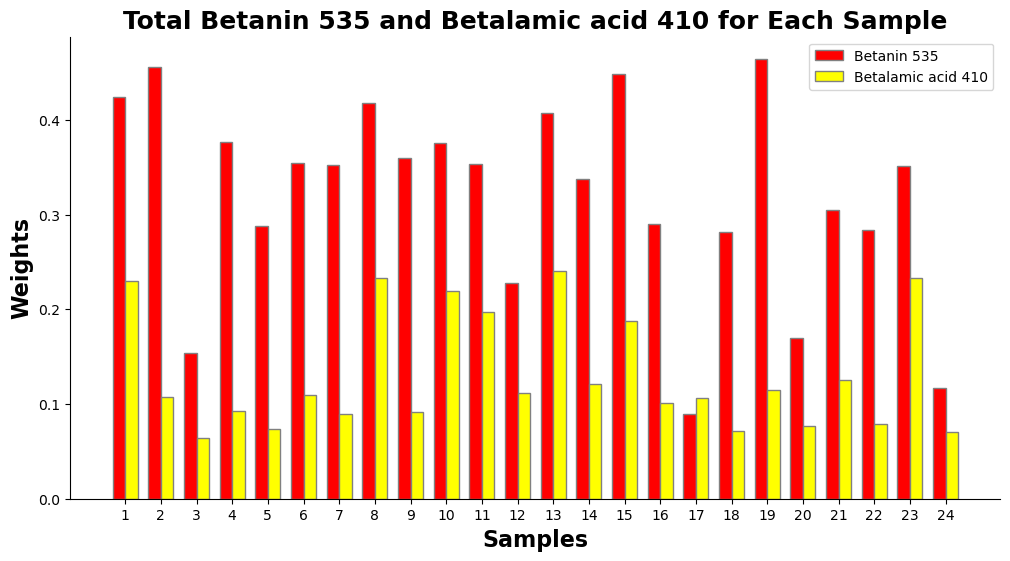

In [155]:
import numpy as np
import matplotlib.pyplot as plt

# Data for the new samples
samples = np.arange(1, 25)  # Samples 1 to 24
betanin_535 = [0.4237, 0.4562, 0.1540, 0.3766, 0.2878, 0.3541, 0.3523, 0.4175, 0.3599, 0.3751,
               0.3535, 0.2283, 0.4074, 0.3371, 0.4489, 0.2896, 0.0897, 0.2817, 0.4646, 0.1701,
               0.3051, 0.2837, 0.3515, 0.1174]
betalamic_acid_410 = [0.2298, 0.1076, 0.0636, 0.0927, 0.0736, 0.1095, 0.0890, 0.2331, 0.0919, 0.2192,
                      0.1972, 0.1119, 0.2403, 0.1213, 0.1874, 0.1012, 0.1061, 0.0711, 0.1151, 0.0768,
                      0.1250, 0.0789, 0.2326, 0.0700]

# Set width of bar
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(samples))
r2 = [x + bar_width for x in r1]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(r1, betanin_535, color='r', width=bar_width, edgecolor='grey', label='Betanin 535')
plt.bar(r2, betalamic_acid_410, color='yellow', width=bar_width, edgecolor='grey', label='Betalamic acid 410')

# Add xticks on the middle of the group bars
plt.xlabel('Samples', fontweight='bold', fontsize = 16)
plt.ylabel('Weights', fontweight='bold',fontsize = 16)
plt.xticks([r + bar_width/2 for r in range(len(samples))], samples)

# Create legend & Show graphic
plt.legend()
plt.title('Total Betanin 535 and Betalamic acid 410 for Each Sample',fontweight='bold', fontsize = 18)
sns.despine()
plt.show()

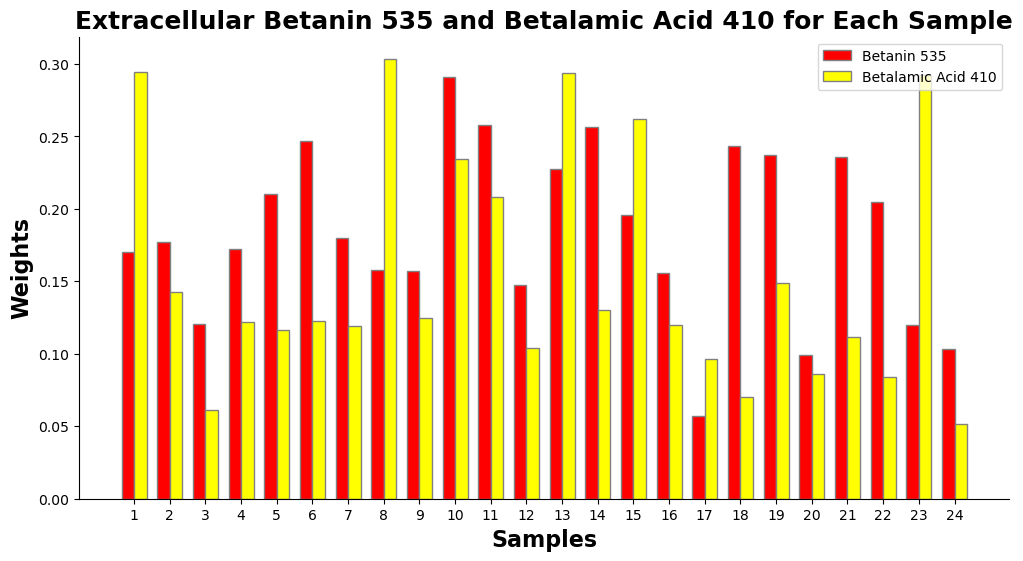

In [159]:
import numpy as np
import matplotlib.pyplot as plt

# Data
samples = np.arange(1, 25)  # Samples 1 to 24
betanin_isobetanin = [0.1701, 0.1774, 0.1204, 0.1723, 0.2106, 0.2468, 0.1797, 0.1580, 0.1568, 0.2910, 
                      0.2579, 0.1472, 0.2276, 0.2563, 0.1959, 0.1557, 0.0572, 0.2433, 0.2375, 0.0994, 
                      0.2356, 0.2050, 0.1202, 0.1035]
fluorescence_betalamic_acid = [0.2941, 0.1423, 0.0609, 0.1220, 0.1167, 0.1227, 0.1189, 0.3036, 0.1247, 0.2347, 
                               0.2080, 0.1043, 0.2937, 0.1301, 0.2623, 0.1199, 0.0961, 0.0701, 0.1487, 0.0859, 
                               0.1119, 0.0839, 0.2926, 0.0516]

# Set width of bar
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(samples))
r2 = [x + bar_width for x in r1]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(r1, betanin_isobetanin, color='red', width=bar_width, edgecolor='grey', label='Betanin 535')
plt.bar(r2, fluorescence_betalamic_acid, color='yellow', width=bar_width, edgecolor='grey', label='Betalamic Acid 410')

# Add xticks on the middle of the group bars
plt.xlabel('Samples', fontweight='bold', fontsize = 16)
plt.ylabel('Weights', fontweight='bold', fontsize = 16)
plt.xticks([r + bar_width/2 for r in range(len(samples))], samples)

# Create legend & Show graphic
plt.legend()
plt.title('Extracellular Betanin 535 and Betalamic Acid 410 for Each Sample', fontweight='bold', fontsize = 18)
sns.despine()
plt.show()

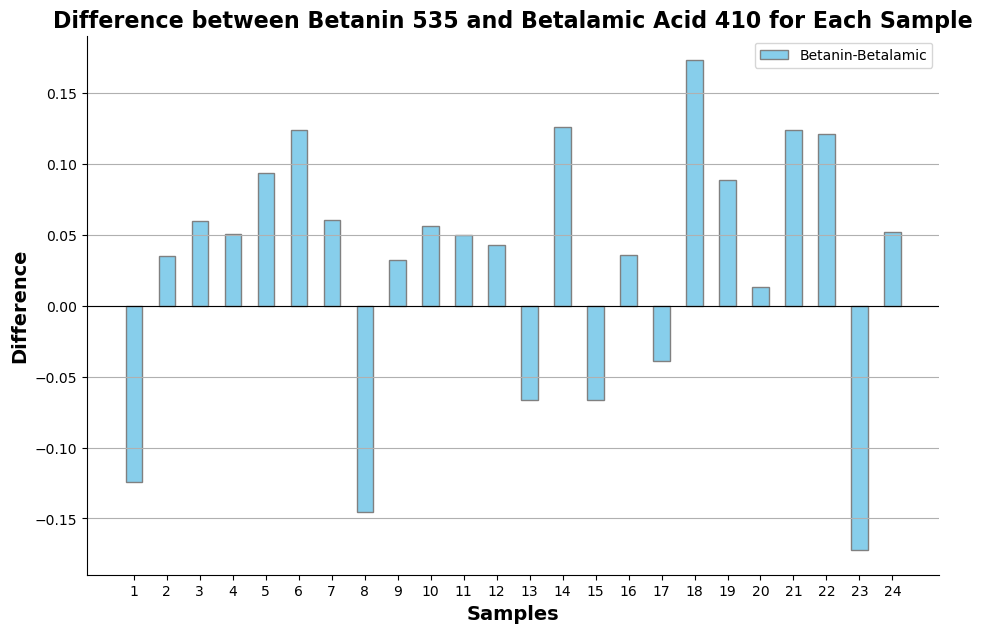

In [168]:
import numpy as np
import matplotlib.pyplot as plt

# Data
samples = np.arange(1, 25)  # Samples 1 to 24
betanin_isobetanin = np.array([0.1701, 0.1774, 0.1204, 0.1723, 0.2106, 0.2468, 0.1797, 0.1580, 0.1568, 0.2910, 
                      0.2579, 0.1472, 0.2276, 0.2563, 0.1959, 0.1557, 0.0572, 0.2433, 0.2375, 0.0994, 
                      0.2356, 0.2050, 0.1202, 0.1035])
fluorescence_betalamic_acid = np.array([0.2941, 0.1423, 0.0609, 0.1220, 0.1167, 0.1227, 0.1189, 0.3036, 0.1247, 0.2347, 
                               0.2080, 0.1043, 0.2937, 0.1301, 0.2623, 0.1199, 0.0961, 0.0701, 0.1487, 0.0859, 
                               0.1119, 0.0839, 0.2926, 0.0516])

# Calculating differences
differences = betanin_isobetanin - fluorescence_betalamic_acid

# Adjusting the plot to add only horizontal grid lines
plt.figure(figsize=(11, 7))
plt.grid(axis='y', linestyle='-')  # Add only horizontal grid lines
bars = plt.bar(samples, differences, color='skyblue', edgecolor='grey', width=0.5)  # Keep the bars narrow and skyblue

# Labeling
plt.xlabel('Samples', fontweight='bold', fontsize = 14)
plt.ylabel('Difference', fontweight='bold', fontsize = 14)
plt.xticks(samples)

plt.axhline(0, color='black', linewidth=0.8)  # Add a line at y=0
plt.title('Difference between Betanin 535 and Betalamic Acid 410 for Each Sample', fontweight='bold', fontsize = 16)


# Adding legend
plt.legend([bars], ['Betanin-Betalamic'], loc='upper right')
sns.despine()
plt.show()



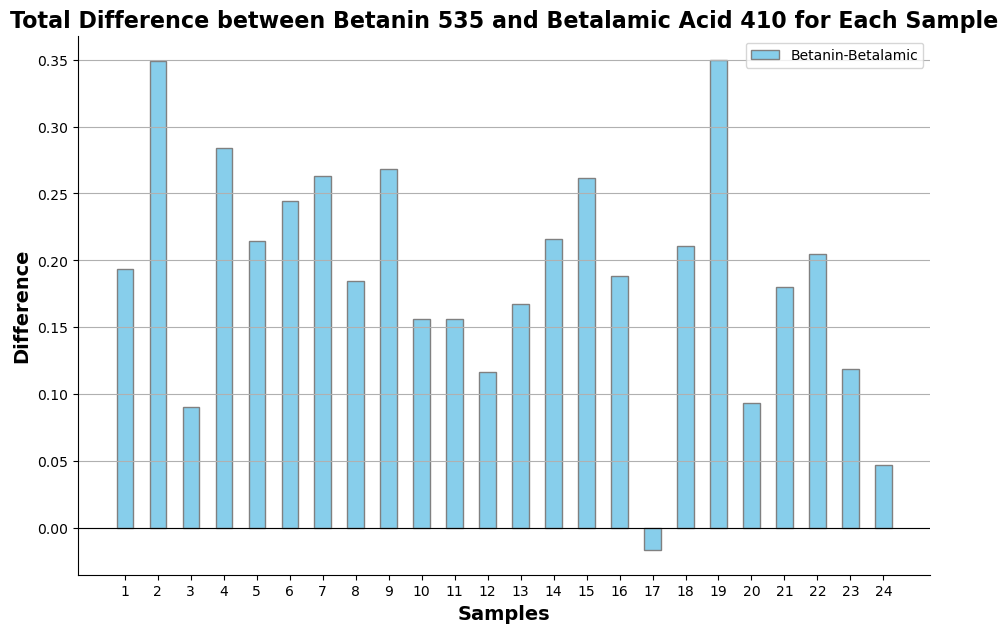

In [175]:
# Data for the new samples
samples = np.arange(1, 25)  # Samples 1 to 24
betanin_535 = np.array([0.4237, 0.4562, 0.1540, 0.3766, 0.2878, 0.3541, 0.3523, 0.4175, 0.3599, 0.3751,
               0.3535, 0.2283, 0.4074, 0.3371, 0.4489, 0.2896, 0.0897, 0.2817, 0.4646, 0.1701,
               0.3051, 0.2837, 0.3515, 0.1174])
betalamic_acid_410 = np.array([0.2298, 0.1076, 0.0636, 0.0927, 0.0736, 0.1095, 0.0890, 0.2331, 0.0919, 0.2192,
                      0.1972, 0.1119, 0.2403, 0.1213, 0.1874, 0.1012, 0.1061, 0.0711, 0.1151, 0.0768,
                      0.1250, 0.0789, 0.2326, 0.0700])


# Calculating differences
differences = betanin_535 - betalamic_acid_410

# Adjusting the plot to add only horizontal grid lines
plt.figure(figsize=(11, 7))
plt.grid(axis='y', linestyle='-')  # Add only horizontal grid lines
bars = plt.bar(samples, differences, color='skyblue', edgecolor='grey', width=0.5)  # Keep the bars narrow and skyblue

# Labeling
plt.xlabel('Samples', fontweight='bold', fontsize = 14)
plt.ylabel('Difference', fontweight='bold', fontsize = 14)
plt.xticks(samples)

plt.axhline(0, color='black', linewidth=0.8)  # Add a line at y=0
plt.title('Total Difference between Betanin 535 and Betalamic Acid 410 for Each Sample', fontweight='bold', fontsize = 16)


# Adding legend
plt.legend([bars], ['Betanin-Betalamic'], loc='upper right')
sns.despine()
plt.show()


In [108]:
dr_trips.head()

,StartTime,EndTime,UserId,latitudeStart,longitudeStart,nameStart,latitudeEnd,longitudeEnd,nameEnd,StartHubClusterId,EndHubClusterId,StartClusterName,EndClusterName,StartClusterLatitude,StartClusterLongitude,EndClusterLatitude,EndClusterLongitude,HaversineDistance,Month,StartHour,Weekday,TripDurationMin,TripDurationHr,SpeedKmHr,RoundTrip,Route,YearMonth,DurationGroup,StartTimeUpdated,TotalDurationMin,TripDistanceKm,TotalWalkingTimeMin,TotalTransitTimeMin,Changes,PickupStationProximity,DropoffStationProximity,SpeedKmHrHav,SpeedKmHrP,DistanceType,UserCategory,UserCluster,DayType,StartZoneId,StartZoneName,StartZoneDescri,EndZoneId,EndZoneName,EndZoneDescri,StartZoneCounts,EndZoneCounts,TripDurationDiff
0,2018-03-01 17:43:14.707445,2018-03-01 18:14:12.145000,108186,55.673440,12.564409,Central Station,55.658239,12.605434,Skotlands Plads,590,331,Central Station,Skotlands Plads,55.673117,12.564212,55.658397,12.605787,3.078446,March,17,Thursday,30.957293,0.515955,6.008277,False,Central Station -> Skotlands Plads,2018-03,0-1 hour,2023-11-16 17:43:14.707445,17.500000,3.86560,6.500000,11.0,0.0,324.78,125.35,5.966503,7.492128,Medium,Occasional Users,1,Weekday,102182.0,Københavns Hovedbanegård,Københavns Kommune syd for Frederiksberg,103173.0,Sundbyvester NNØ,"Københavns Kommune, Amager",1631,207,-13.457293
1,2018-03-03 13:22:27.557683,2018-03-03 13:40:09.817000,109897,55.673668,12.571551,H. C. Andersens Blvd.,55.668555,12.547020,Broagergade,579,564,Ved Glyptoteket,Broagergade,55.672956,12.570784,55.669073,12.546464,1.640003,March,13,Saturday,17.704322,0.295072,10.505909,False,Ved Glyptoteket -> Broagergade,2018-03,0-1 hour,2023-11-18 13:22:27.557683,15.533333,2.69815,10.533333,5.0,0.0,80.07,677.63,5.557974,9.144038,Short,Occasional Users,2,Weekend,102172.0,Tivoli,"Københavns Kommune, indre by og Christianshavn",102821.0,Vesterbro N,Københavns Kommune syd for Frederiksberg,797,1822,-2.170989
2,2018-03-06 07:45:32.192047,2018-03-06 08:09:27.571000,1,55.672142,12.590571,Christianshavn,55.665808,12.578714,Egilsgade,50,542,Christianshavn,Egilsgade,55.672121,12.590597,55.665262,12.579198,1.024221,March,7,Tuesday,23.922983,0.398716,7.774950,False,Christianshavn -> Egilsgade,2018-03,0-1 hour,2023-11-21 07:45:32.192047,15.233333,1.87281,14.233333,1.0,0.0,100.86,538.09,2.568796,4.697098,Short,Moderately Active Users,2,Weekday,103142.0,Christianshavn S,"Københavns Kommune, indre by og Christianshavn",103193.0,Islands Brygge S,"Københavns Kommune, Amager",837,1407,-8.689649
3,2018-03-07 09:14:43.451300,2018-03-07 09:44:31.006000,14,55.682597,12.571227,Nørreport St.,55.666573,12.580692,Founders House,40,538,Nørreport St.,Founders House,55.683061,12.570524,55.666721,12.579745,1.878027,March,9,Wednesday,29.792578,0.496543,6.243166,False,Nørreport St. -> Founders House,2018-03,0-1 hour,2023-11-15 09:14:43.451300,22.550000,4.49931,12.333333,8.0,1.0,190.22,116.28,3.782205,9.061270,Short,Occasional Users,2,Weekday,102141.0,Rundetårn,"Københavns Kommune, indre by og Christianshavn",103193.0,Islands Brygge S,"Københavns Kommune, Amager",2763,1407,-7.242578
4,2018-03-08 08:57:15.603150,2018-03-08 09:33:33.622000,114469,55.668653,12.543646,Vega,55.701914,12.533708,Frederikssundsvej,562,267,Vega,Frederikssundsvej,55.668626,12.543944,55.702002,12.533122,3.750543,March,8,Thursday,36.300314,0.605005,5.123923,False,Vega -> Frederikssundsvej,2018-03,0-1 hour,2023-11-16 08:57:15.603150,23.733333,5.81268,13.733333,10.0,0.0,267.99,375.18,6.199191,9.607652,Medium,Occasional Users,1,Weekday,102821.0,Vesterbro N,Københavns Kommune syd for Frederiksberg,102541.0,Utterslev NØ,Københavns Kommune Nord,1838,676,-12.566981


In [109]:
dr_trips.StartTime.min(), dr_trips.StartTime.max()

('2018-03-01 16:26:42.857427', '2019-04-02 12:25:08.815354')

In [110]:
dr_trips.columns

Index(['StartTime', 'EndTime', 'UserId', 'latitudeStart', 'longitudeStart',
       'nameStart', 'latitudeEnd', 'longitudeEnd', 'nameEnd',
       'StartHubClusterId', 'EndHubClusterId', 'StartClusterName',
       'EndClusterName', 'StartClusterLatitude', 'StartClusterLongitude',
       'EndClusterLatitude', 'EndClusterLongitude', 'HaversineDistance',
       'Month', 'StartHour', 'Weekday', 'TripDurationMin', 'TripDurationHr',
       'SpeedKmHr', 'RoundTrip', 'Route', 'YearMonth', 'DurationGroup',
       'StartTimeUpdated', 'TotalDurationMin', 'TripDistanceKm',
       'TotalWalkingTimeMin', 'TotalTransitTimeMin', 'Changes',
       'PickupStationProximity', 'DropoffStationProximity', 'SpeedKmHrHav',
       'SpeedKmHrP', 'DistanceType', 'UserCategory', 'UserCluster', 'DayType',
       'StartZoneId', 'StartZoneName', 'StartZoneDescri', 'EndZoneId',
       'EndZoneName', 'EndZoneDescri', 'StartZoneCounts', 'EndZoneCounts',
       'TripDurationDiff'],
      dtype='object')

In [111]:
# drop StartZoneId and EndZoneId
#dr_trips = dr_trips.drop(['StartZoneId', 'EndZoneId'], axis=1)


In [112]:
# drop duplicates
filtered_stops.drop_duplicates(subset=['stop_name'], inplace=True)
# create new categorical column called station_type
# if stop_name contains 'Metro' then station_type is 'Metro'
# if stop name ends with 'St.' then station_type is 'S-Train'
# else station_type is 'Bus'
filtered_stops['station_type'] = np.where(filtered_stops['stop_name'].str.contains('Metro'), 'Metro', 
                                          np.where(filtered_stops['stop_name'].str.endswith('St.'), 'S-Train', 'Bus'))
# set station_type to categorical
filtered_stops['station_type'] = filtered_stops['station_type'].astype('category')

In [113]:
# remove rows where station_type is Bus
filtered_stops = filtered_stops[filtered_stops['station_type'] != 'Bus']

In [114]:
# save dr_trips to csv
dr_trips.to_csv('../data/processed/dr_trips_oneway_cleaned_zone.csv', index=False)

In [115]:
map = KeplerGl( height=700,)
#map.add_data(data=dr_trips, name='Donkey Republic Trips')
map.add_data(data=dr_trips, name='BIke Trips')
map.add_data(data=cph, name='Copenhagen Area')
map.add_data(filtered_stops, name='Public Transport Stops')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [116]:
map.save_to_html(file_name='../data/processed/kepler_map_bikes.html')

Map saved to ../data/processed/kepler_map_bikes.html!


In [117]:
# Example setup for aggregated_gdf
# aggregated_gdf = gpd.read_file('path_to_your_aggregated_shapefile.shp')  # Adjust as necessary

# Convert geometries to GeoJSON strings
#aggregated_gdf['geometry_geojson'] = aggregated_gdf['geometry'].apply(lambda x: gpd.GeoSeries([x]).to_json())

# Assuming 'zonedescri' is the column in aggregated_gdf that matches with StartZoneDescri and EndZoneDescri in dr_trips
# start_geom_map = aggregated_gdf.set_index('zonedescri')['geometry']
# end_geom_map = aggregated_gdf.set_index('zonedescri')['geometry']
# # Map the GeoJSON strings to dr_trips
# dr_trips['StartGeometry'] = dr_trips['StartZoneDescri'].map(start_geom_map)
# dr_trips['EndGeometry'] = dr_trips['EndZoneDescri'].map(end_geom_map)



In [118]:
# dr_trips = dr_trips.rename(columns={'StartGeometry': 'geometry'})
# # convert to geodataframe
# dr_trips = gpd.GeoDataFrame(dr_trips, geometry='geometry')
# # rename StartGeometry to geometry


In [119]:
# # If `dr_trips` is a GeoDataFrame and contains 'geometry' column
# if isinstance(dr_trips, gpd.GeoDataFrame) and 'StartGeometry' in dr_trips:
#     dr_trips['StartGeometry'] = dr_trips['StartGeometry'].apply(lambda geom: geom.__geo_interface__)

# # If `dr_trips` is a GeoDataFrame and contains 'geometry' column
# if isinstance(dr_trips, gpd.GeoDataFrame) and 'EndGeometry' in dr_trips:
#     dr_trips['EndGeometry'] = dr_trips['EndGeometry'].apply(lambda geom: geom.__geo_interface__)


In [120]:
# Create a KeplerGl map
#map_ = KeplerGl(height=600)

# Add the dr_trips DataFrame to the map
# Since the geometries are in WKT format, they should be automatically recognized and plotted
#map_.add_data(data=dr_trips, name='Trips')

# Display the map
#map_

For the Kmeans we agnowledge there is a problem with correlated features and that using PCA and GMM would solve this problem. However, we will use the Kmeans algorithm to cluster the data and then use the GMM to cluster the data. We will then compare the results of the two algorithms.

#### Explore the accessibility map

color code the map based on the differences between the pub transport and the time it takes by bike 
for all trips that start in 1 hub we get the difference between the time it takes by bike and the time it takes by public transport. We then average the differences for all trips that start in the same hub. We then color code the map based on the average differences.
Show a histogram of the differences 
